### Grover

In [1]:
# --- Imports ---
from qiskit import QuantumCircuit, transpile
from qiskit.primitives import StatevectorSampler
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZGate
from qiskit.visualization import plot_histogram
import numpy as np

# --- 1. Definir el Espacio de Búsqueda y la Contraseña ---

# Usemos 4 qubits, lo que nos da un espacio de 2^4 = 16 posibles contraseñas.
n_qubits = 4

# La contraseña que queremos encontrar """perdida""" (ponele...)
# Por ejemplo, '1101'
secret_key = '1101' 

In [2]:
def oracle(circuit, key):
    """
    Implementa el oráculo que marca el estado 'key'.
    """
    # Invertimos la clave para que coincida con el orden de qubits de Qiskit (q_n-1...q_0)
    reversed_key = key[::-1]
    
    # Aplicamos compuertas X a los qubits que son '0' en la clave
    for i, bit in enumerate(reversed_key):
        if bit == '0':
            circuit.x(i)
    
    # Aplicamos una compuerta Z multi-controlada
    num_qubits = circuit.num_qubits
    circuit.append(ZGate().control(num_qubits - 1), range(num_qubits))
    
    # Revertimos las compuertas X
    for i, bit in enumerate(reversed_key):
        if bit == '0':
            circuit.x(i)


In [3]:
# --- 3. Implementar el Difusor de Grover ---
# El difusor amplifica la amplitud del estado marcado.

def diffuser(circuit, n):
    """
    Implementa el difusor de Grover para n qubits.
    """
    # Se implementa como H...H -> X...X -> MCZ -> X...X -> H...H
    circuit.h(range(n))
    circuit.x(range(n))
    
    # Compuerta Z multi-controlada
    circuit.append(ZGate().control(n - 1), range(n))
    
    circuit.x(range(n))
    circuit.h(range(n))


In [4]:
# Inicialización: Aplicar Hadamard a todos los qubits
grover_circuit = QuantumCircuit(n_qubits, n_qubits)
grover_circuit.h(range(n_qubits))
grover_circuit.barrier()

# --- Aplicar Grover (Oráculo + Difusor) ---
# El número óptimo de iteraciones es aprox. (pi/4) * sqrt(2^n)
iterations = int(np.round(np.pi/4 * np.sqrt(2**n_qubits)))
print(f"Número de qubits: {n_qubits}, Iteraciones de Grover: {iterations}")
qbits_list = [i for i in range(n_qubits)]

for _ in range(iterations):
    oracle(grover_circuit, secret_key)
    grover_circuit.barrier()
    diffuser(grover_circuit, n_qubits)
    grover_circuit.barrier()



Número de qubits: 4, Iteraciones de Grover: 3


In [5]:
# --- 5. Medición ---
grover_circuit.measure(range(n_qubits), range(n_qubits))

# Imprimimos el circuito
print(grover_circuit)

     ┌───┐ ░               ░ ┌───┐┌───┐   ┌───┐┌───┐ ░               ░ ┌───┐»
q_0: ┤ H ├─░───────■───────░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░───────■───────░─┤ H ├»
     ├───┤ ░ ┌───┐ │ ┌───┐ ░ ├───┤├───┤ │ ├───┤├───┤ ░ ┌───┐ │ ┌───┐ ░ ├───┤»
q_1: ┤ H ├─░─┤ X ├─■─┤ X ├─░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░─┤ X ├─■─┤ X ├─░─┤ H ├»
     ├───┤ ░ └───┘ │ └───┘ ░ ├───┤├───┤ │ ├───┤├───┤ ░ └───┘ │ └───┘ ░ ├───┤»
q_2: ┤ H ├─░───────■───────░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░───────■───────░─┤ H ├»
     ├───┤ ░       │       ░ ├───┤├───┤ │ ├───┤├───┤ ░       │       ░ ├───┤»
q_3: ┤ H ├─░───────■───────░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░───────■───────░─┤ H ├»
     └───┘ ░               ░ └───┘└───┘   └───┘└───┘ ░               ░ └───┘»
c: 4/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───┐   ┌───┐┌───┐ ░               ░ ┌───┐┌───┐   ┌───┐┌───┐ ░ ┌─┐      »
«q_0: ┤ X ├─■─┤ X ├┤ H ├─░───────■───────░─┤ H ├┤ X ├─■─┤ X ├┤

In [6]:
# --- 6. Simulación ---
# Usamos AerSimulator para simular el circuito.
backend = AerSimulator()
transpiled_circuit = transpile(grover_circuit, backend)
job = backend.run(transpiled_circuit, shots=1024)
results = job.result()
counts = results.get_counts(transpiled_circuit)

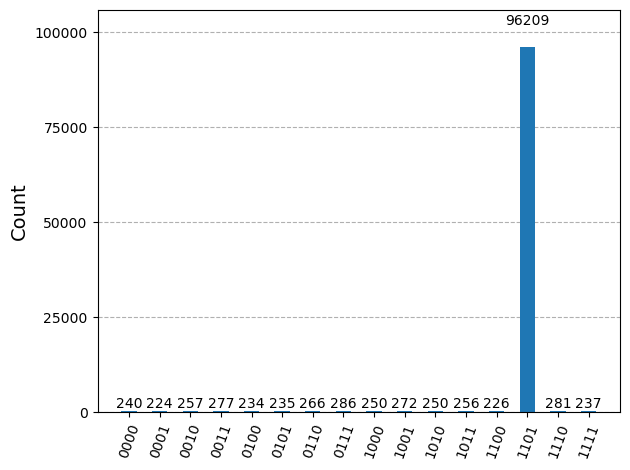

In [7]:
sampler = StatevectorSampler()
shots = 100000

job = sampler.run([grover_circuit], shots=shots)

result = job.result()[0]
counts = result.data.c.get_counts()

plot_histogram(counts)

In [8]:
# Encontrar la contraseña más probable
most_probable_key = max(counts, key=counts.get)
print(f"\nLa contraseña más probable encontrada es: {most_probable_key}")
print(f"La contraseña secreta era: {secret_key}")


La contraseña más probable encontrada es: 1101
La contraseña secreta era: 1101


### Ruido y visualización

In [9]:
from utils import create_grover_circuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.noise import NoiseModel, depolarizing_error
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def modelo_de_ruido(gate_error=0.001, measurement_error=0.01):
    """
    ruido uniforme
    
    Args:
        gate_error: probabilidad de error
        measurement_error: probabildad para medidas
    
    Returns:
        NoiseModel
    """
    noise_model = NoiseModel()
    
    # 1qubit (H, X, etc.)
    error_1q = depolarizing_error(gate_error, 1)
    noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x'])
    
    # 2qb (CX, CCX)
    error_2q = depolarizing_error(gate_error * 10, 2)  # empeora en 10x 
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
    
    # para A de Grover
    error_mcx = depolarizing_error(gate_error * 20, 3)  # mas pior
    noise_model.add_all_qubit_quantum_error(error_mcx, ['mcx'])
    
    # Measurement errors
    error_meas = [[1 - measurement_error, measurement_error],
        [measurement_error, 1 - measurement_error]]
    noise_model.add_all_qubit_readout_error(error_meas)
    
    return noise_model

In [10]:
# --- Parámetros para la Experimentación ---
qubit_range = [4, 6, 8, 12]  
error_range = np.logspace(-4, -2, 5)
shots = 2048
results_data = []


--- Probando con 4 qubits (clave: 1111) ---
  Corriendo con error de compuerta: 0.0001
Número de qubits: 4, Iteraciones de Grover: 3
  Corriendo con error de compuerta: 0.0003
Número de qubits: 4, Iteraciones de Grover: 3
  Corriendo con error de compuerta: 0.0010
Número de qubits: 4, Iteraciones de Grover: 3
  Corriendo con error de compuerta: 0.0032
Número de qubits: 4, Iteraciones de Grover: 3
  Corriendo con error de compuerta: 0.0100
Número de qubits: 4, Iteraciones de Grover: 3

--- Probando con 6 qubits (clave: 010100) ---
  Corriendo con error de compuerta: 0.0001
Número de qubits: 6, Iteraciones de Grover: 6
  Corriendo con error de compuerta: 0.0003
Número de qubits: 6, Iteraciones de Grover: 6
  Corriendo con error de compuerta: 0.0010
Número de qubits: 6, Iteraciones de Grover: 6
  Corriendo con error de compuerta: 0.0032
Número de qubits: 6, Iteraciones de Grover: 6
  Corriendo con error de compuerta: 0.0100
Número de qubits: 6, Iteraciones de Grover: 6

--- Probando con 

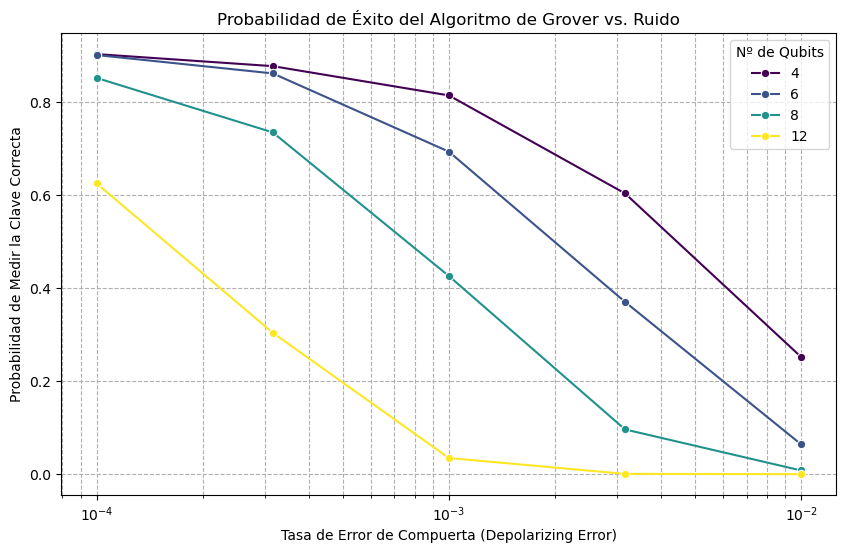

In [11]:
# --- Bucle de Simulación ---
for n_qubits in qubit_range:
    # Generar una clave secreta aleatoria para este tamaño
    secret_key = ''.join(np.random.choice(['0', '1'], size=n_qubits))
    print(f"\n--- Probando con {n_qubits} qubits (clave: {secret_key}) ---")
    
    for gate_error in error_range:
        print(f"  Corriendo con error de compuerta: {gate_error:.4f}")
        
        # 1. Crear el modelo de ruido
        noise_environment = modelo_de_ruido(gate_error=gate_error)
        backend = AerSimulator(noise_model=noise_environment)
        
        # 2. Crear y transpilar el circuito de Grover
        grover_circuit = create_grover_circuit(n_qubits, secret_key)
        transpiled_circuit = transpile(grover_circuit, backend)
        
        # 3. Ejecutar la simulación
        job = backend.run(transpiled_circuit, shots=shots)
        results = job.result()
        counts = results.get_counts(transpiled_circuit)
        
        # 4. Calcular y almacenar la probabilidad de éxito
        success_prob = counts.get(secret_key, 0) / shots
        results_data.append({
            'n_qubits': n_qubits,
            'gate_error': gate_error,
            'success_prob': success_prob
        })

# --- Análisis y Visualización de Resultados ---
df = pd.DataFrame(results_data)
print("\n--- Resultados del Experimento ---")
print(df)

# Crear la gráfica
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='gate_error', y='success_prob', hue='n_qubits', marker='o', palette='viridis')

plt.xscale('log')
plt.title('Probabilidad de Éxito del Algoritmo de Grover vs. Ruido')
plt.xlabel('Tasa de Error de Compuerta (Depolarizing Error)')
plt.ylabel('Probabilidad de Medir la Clave Correcta')
plt.grid(True, which="both", ls="--")
plt.legend(title='Nº de Qubits')
plt.show()